In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from ipywidgets import interact, fixed, IntSlider, Checkbox
from pathlib import Path
# Instalamos el paquete de utilidades
%pip install -qq git+https://github.com/udesa-vision/i308-utils.git

from i308_utils import imshow, show_images
from utils import rectify_stereo_pair, draw_epipolar_lines, show_pair_any, compute_depth

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cargamos los archivos y analizamos el contenido
with open('data/pkls/stereo_calibration.pkl', 'rb') as f:
    calib = pickle.load(f)

with open('data/pkls/stereo_maps.pkl', 'rb') as f:
    maps = pickle.load(f)

print('Calibration keys:', calib.keys())
print('Maps keys:', maps.keys())

Calibration keys: dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])
Maps keys: dict_keys(['left_map_x', 'left_map_y', 'right_map_x', 'right_map_y', 'R1', 'R2', 'P1', 'P2', 'Q', 'validRoi1', 'validRoi2'])


Pares rectificados: 23


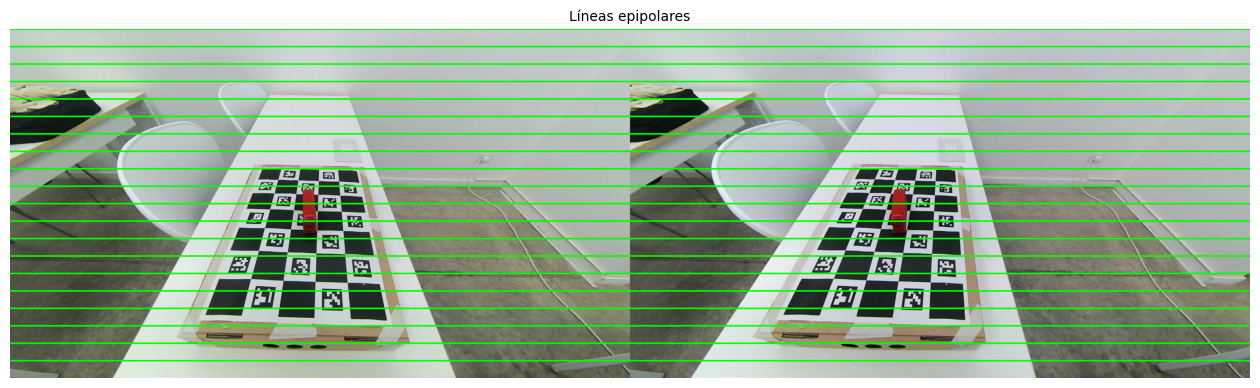

In [3]:
# Rectificamos los pares estéreo
in_dir = Path('data/captures')
out_dir = Path('data/rectified')
out_dir.mkdir(exist_ok=True)

indices = list(range(14, 37))

procesados = 0
faltantes = []

for i in indices:
    left_path = in_dir / f'left_{i}.jpg'
    right_path = in_dir / f'right_{i}.jpg'
    if not left_path.exists() or not right_path.exists():
        faltantes.append(i)
        continue

    rectL, rectR = rectify_stereo_pair(str(left_path), str(right_path), maps)

    # Guardar
    cv2.imwrite(str(out_dir / f'rect_left_{i}.jpg'), rectL)
    cv2.imwrite(str(out_dir / f'rect_right_{i}.jpg'), rectR)
    procesados += 1

print(f'Pares rectificados: {procesados}')
if faltantes:
    print('Índices faltantes:', faltantes)

# Visualizamos un par de imágenes rectificadas con líneas epipolares
combinados = draw_epipolar_lines(rectL, rectR)
imshow(combinados, title='Líneas epipolares', figsize=(16, 8))

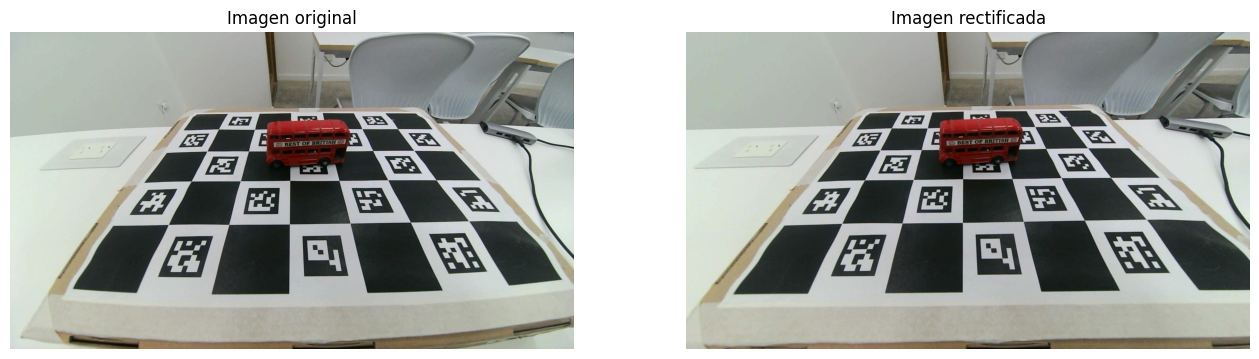

In [4]:
imgL = cv2.imread('data/captures/left_14.jpg')
rectifiedL = cv2.remap(imgL, maps['left_map_x'], maps['left_map_y'], cv2.INTER_LINEAR)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Imagen original')
plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Imagen rectificada')
plt.imshow(cv2.cvtColor(rectifiedL, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [5]:
idx_slider = IntSlider(min=14, max=37, step=1, value=14, layout={'width': '900px'})
lines_slider = IntSlider(min=5, max=50, step=5, value=20, layout={'width': '400px'})

interact(
    show_pair_any,
    idx=idx_slider,
    draw_lines=Checkbox(value=True, description='Rectificar'),
    num_lines=lines_slider,
    stereo_maps=fixed(maps)
)

interactive(children=(IntSlider(value=14, description='idx', layout=Layout(width='900px'), max=37, min=14), Ch…

<function utils.show_pair_any(idx=14, rectificar=True, num_lines=20, stereo_maps=None)>

## Cálculo de Disparidad
### Block Matching

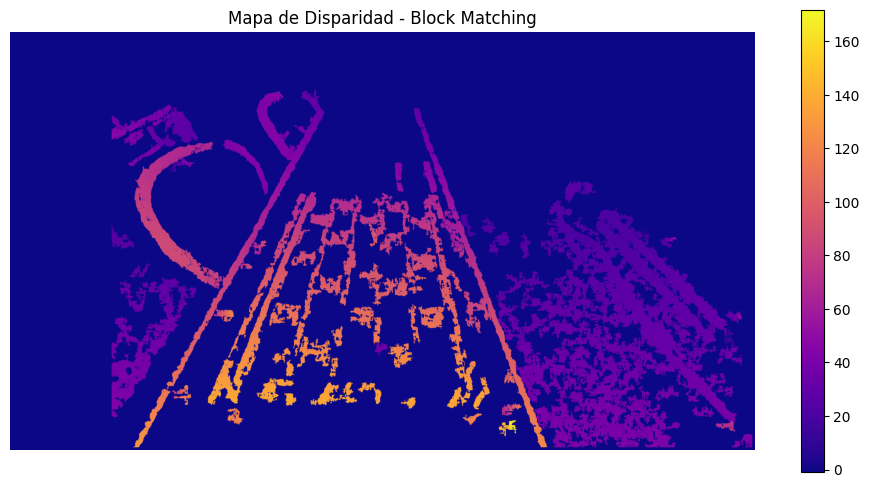

In [6]:
stereo_bm = cv2.StereoBM_create(numDisparities=256, blockSize=15)

stereo_bm.setPreFilterSize(31)
stereo_bm.setPreFilterCap(15)
stereo_bm.setMinDisparity(0)
stereo_bm.setTextureThreshold(7)
stereo_bm.setUniquenessRatio(3)
stereo_bm.setSpeckleWindowSize(512)
# stereo_bm.setSpeckleWindowSize(0)
stereo_bm.setSpeckleRange(32)
stereo_bm.setDisp12MaxDiff(23)

# Pasamos las imágenes rectificadas a escala de grises
rectL_gray = cv2.cvtColor(rectL, cv2.COLOR_BGR2GRAY)
rectR_gray = cv2.cvtColor(rectR, cv2.COLOR_BGR2GRAY)

# Cálculo del mapa de disparidad
disparity_map_bm = stereo_bm.compute(
    rectL_gray,
    rectR_gray
).astype(np.float32) / 16.0

plt.figure(figsize=(12, 6))
plt.imshow(disparity_map_bm, cmap='plasma')
plt.colorbar()
plt.title('Mapa de Disparidad - Block Matching')
plt.axis('off')
plt.show()

### Semi-Global Block Matching

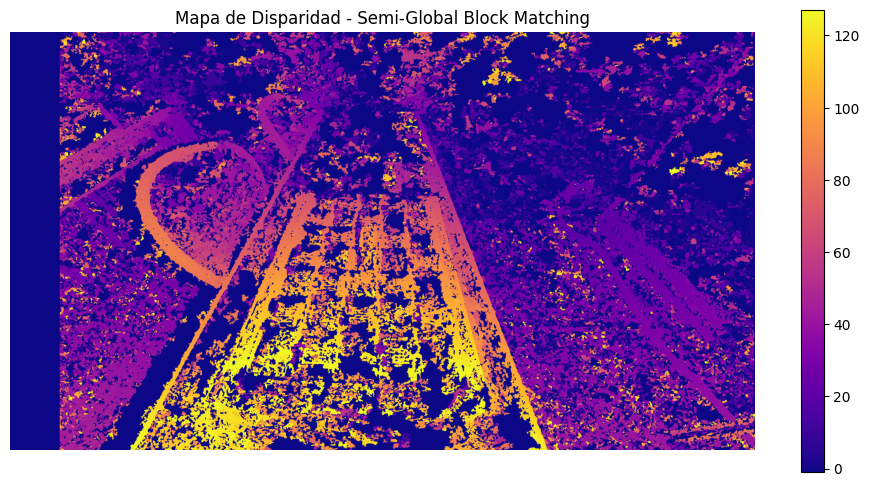

In [7]:
stereo_sgbm = cv2.StereoSGBM_create(numDisparities=128, blockSize=7)

# stereo_sgbm.setBlockSize(3)
# stereo_sgbm.setMode()

stereo_sgbm.setP1(16)
stereo_sgbm.setP2(128)
stereo_sgbm.setUniquenessRatio(7)
stereo_sgbm.setSpeckleWindowSize(512)
stereo_sgbm.setSpeckleRange(64)
stereo_sgbm.setDisp12MaxDiff(1)
stereo_sgbm.setPreFilterCap(63)

# Cálculo del mapa de disparidad
disparity_map_sgbm = stereo_sgbm.compute(
    rectL_gray,
    rectR_gray
).astype(np.float32) / 16.0

plt.figure(figsize=(12, 6))
plt.imshow(disparity_map_sgbm, cmap='plasma')
plt.colorbar()
plt.title('Mapa de Disparidad - Semi-Global Block Matching')
plt.axis('off')
plt.show()

### Cre Stereo

In [8]:
%pip install -qq onnxruntime

Note: you may need to restart the kernel to use updated packages.


In [9]:
width, height = rectL_gray.shape[1], rectL_gray.shape[0]

fx = calib['left_K'][0][0]
fy = calib['left_K'][1][1]
cx0 = calib['left_K'][0][2]
cy0 = calib['left_K'][1][2]

baseline = np.linalg.norm(calib['T'])  # Distancia entre cámaras

models/crestereo_combined_iter5_720x1280.onnx


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


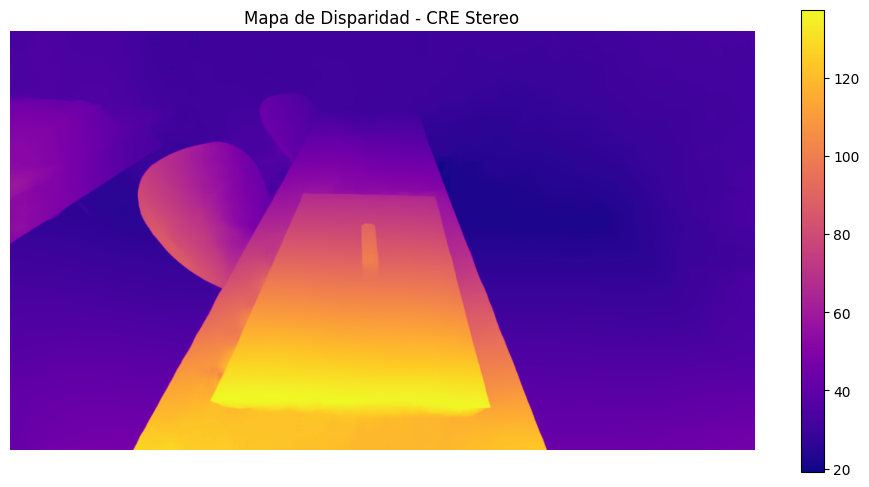

In [10]:
from disparity.methods import Calibration, InputPair, Config
from disparity.method_cre_stereo import CREStereo

calibration = Calibration(**{
    "width": width,
    "height": height,
    "baseline_meters": baseline / 1000,
    "fx": fx,
    "fy": fy,
    "cx0": cx0,
    "cx1": cx0,
    "cy": cy0,
    "depth_range": [0.05, 20.0],
    "left_image_rect_normalized": [0, 0, 1, 1]
})

models_path = "models"
if not os.path.exists(models_path):
    os.makedirs(models_path)
models_path = Path(models_path)
pair = InputPair(
    left_image=rectL_gray,
    right_image=rectR_gray,
    calibration=calibration
)
config = Config(models_path=models_path)

cre_stereo = CREStereo(config)
cre_stereo.parameters['Shape'].set_value('1280x720')

disparity_map_cs = cre_stereo.compute_disparity(pair)
plt.figure(figsize=(12, 6))
plt.imshow(disparity_map_cs.disparity_pixels, cmap='plasma')
plt.colorbar()
plt.title('Mapa de Disparidad - CRE Stereo')
plt.axis('off')
plt.show()

### Cálculo de Profundidad

Usamos la fórmula:
$ z = \frac{f . B}{d} $

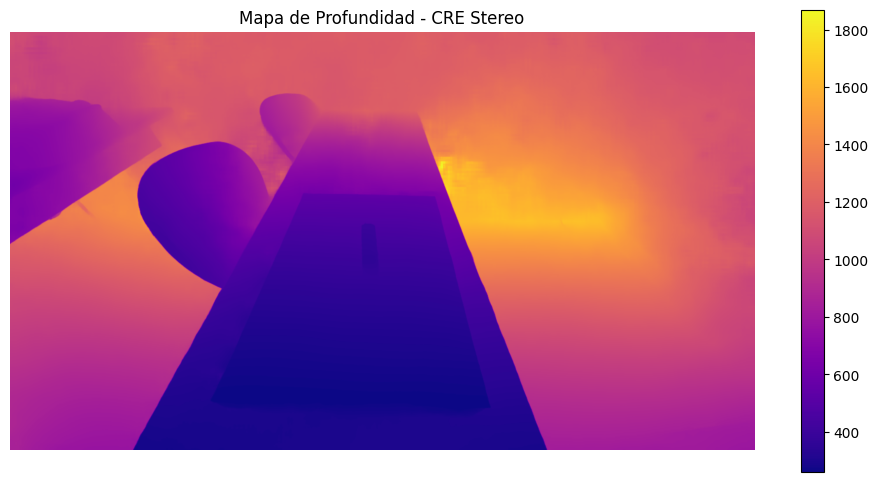

In [11]:
disparity_map_cs_px = disparity_map_cs.disparity_pixels

f = calib['left_K'][0][0]  # Focal en píxeles
B = baseline

depth_map_cs_px = compute_depth(disparity_map_cs_px, f, B)

plt.figure(figsize=(12, 6))
plt.imshow(depth_map_cs_px, cmap='plasma')
plt.colorbar()
plt.title('Mapa de Profundidad - CRE Stereo')
plt.axis('off')
plt.show()

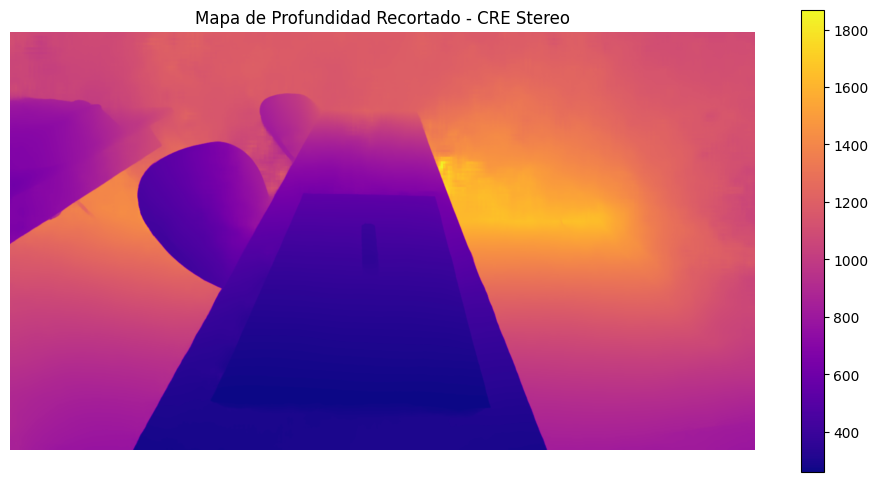

In [12]:
depth_map_cs_px2 = depth_map_cs_px.copy()
depth_map_cs_px2[depth_map_cs_px2 > 10000] = 10000

plt.figure(figsize=(12, 6))
plt.imshow(depth_map_cs_px2, cmap='plasma')
plt.colorbar()
plt.title('Mapa de Profundidad Recortado - CRE Stereo')
plt.axis('off')
plt.show()

# Detección de patrón y pose


In [13]:
#ya teniendo el mapa de profundidad, podemos encontrar la nube de puntos 3D
#para eso necesitamos la matriz Q de reproyección, que se obtiene a partir de la rectificacion

#primero debo encontrar la pose de la camara izquierda con respercto al mundo 
#se calcula en relacion a un patron conocido 
#usar cv.findChessboardCorners y cv.solvePnP



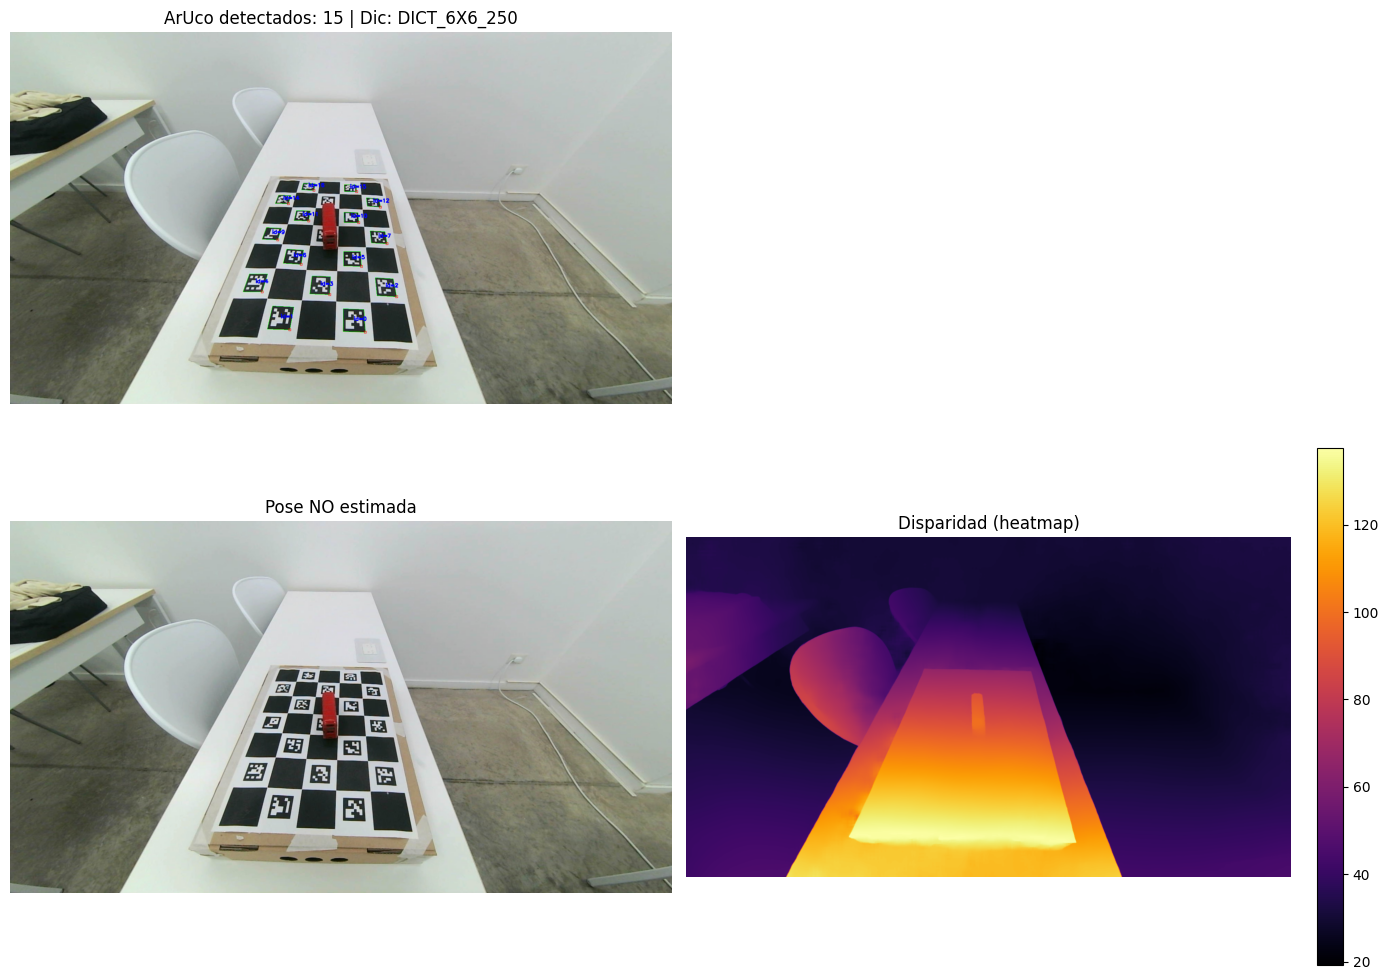

Pose NO estimada: revisá diccionario/tamaños, enfoque y que el tablero no pise bordes negros.


In [ ]:

Q = maps['Q']
P1 = maps['P1']
disparity = disparity_map_cs_px
left_img_rect = rectL  # BGR

# =========================
# Config Charuco
# =========================
import cv2, numpy as np, matplotlib.pyplot as plt
from matplotlib import gridspec

CHARUCO_CONFIG = {
    "squares_x":        5,            # cuadrados totales en X
    "squares_y":        7,            # cuadrados totales en Y
    "square_length_mm": 30.0,         # lado del cuadrado (mm)
    "marker_length_mm": 20.0,         # lado del marcador (mm)
    "dict_name":        "DICT_6X6_250"
}

dictionary = cv2.aruco.getPredefinedDictionary(
    getattr(cv2.aruco, CHARUCO_CONFIG["dict_name"])
)


board = cv2.aruco.CharucoBoard(
    (int(CHARUCO_CONFIG["squares_x"]), int(CHARUCO_CONFIG["squares_y"])),
    CHARUCO_CONFIG["square_length_mm"]/1000.0,
    CHARUCO_CONFIG["marker_length_mm"]/1000.0,
    dictionary
)


def make_hmat_from_rvec_tvec(rvec, tvec):
    R, _ = cv2.Rodrigues(rvec)
    H = np.eye(4, dtype=np.float64)
    H[:3,:3] = R
    H[:3, 3] = tvec.reshape(3)
    return H

def invert_hmat(H):
    R, t = H[:3,:3], H[:3,3]
    Hin = np.eye(4, dtype=H.dtype)
    Hin[:3,:3] = R.T
    Hin[:3, 3] = -R.T @ t
    return Hin

def transform_points_h(points_xyz, H):
    N = points_xyz.shape[0]
    pts_h = np.c_[points_xyz, np.ones((N,1), dtype=points_xyz.dtype)]
    out_h = (H @ pts_h.T).T
    return out_h[:, :3] / out_h[:, 3:4]

def reproject_disparity_to_points(disparity, Q, color_bgr=None, min_disp=1.0):
    disp = disparity.astype(np.float32, copy=False)
    pts3d = cv2.reprojectImageTo3D(disp, Q)  # (H,W,3) en coords cámara IZQ
    valid = np.isfinite(pts3d).all(axis=2) & (disp > min_disp)
    pts = pts3d[valid]
    colors = None
    if color_bgr is not None:
        colors = cv2.cvtColor(color_bgr, cv2.COLOR_BGR2RGB)[valid]
    return pts, valid, colors

def build_charuco_object_points_from_ids(sx, sy, square_size_mm, ch_ids):
    ncols = int(sx) - 1
    ids = ch_ids.ravel().astype(int)
    objp = np.zeros((len(ids), 3), dtype=np.float32)
    for i, k in enumerate(ids):
        ix = k % ncols
        iy = k // ncols
        objp[i, 0] = ix * float(square_size_mm)
        objp[i, 1] = iy * float(square_size_mm)
    return objp


K_use  = P1[:3, :3].copy().astype(np.float32)           # intrínsecos de la RECTIFICADA
dist_0 = np.zeros((5,1), dtype=np.float32)              # SIN distorsión en rectificada
grayL  = cv2.cvtColor(left_img_rect, cv2.COLOR_BGR2GRAY)

try:
    params = cv2.aruco.DetectorParameters()
except Exception:
    params = cv2.aruco.DetectorParameters_create()
params.cornerRefinementMethod = getattr(cv2.aruco, "CORNER_REFINE_SUBPIX", 1)
params.adaptiveThreshWinSizeMin = 3
params.adaptiveThreshWinSizeMax = 53
params.adaptiveThreshWinSizeStep = 10
params.minMarkerPerimeterRate = 0.02
params.maxMarkerPerimeterRate = 4.0

if hasattr(cv2.aruco, "ArucoDetector"):
    detector = cv2.aruco.ArucoDetector(dictionary, params)
    corners, ids, rejected = detector.detectMarkers(grayL)
else:
    corners, ids, rejected = cv2.aruco.detectMarkers(grayL, dictionary, parameters=params)

# Visual: marcadores detectados
fig = plt.figure(figsize=(14,10))
gs  = gridspec.GridSpec(2, 2, height_ratios=[1,1.2])

ax0 = fig.add_subplot(gs[0,0])
img_dbg = left_img_rect.copy()
if ids is not None and len(ids)>0:
    cv2.aruco.drawDetectedMarkers(img_dbg, corners, ids)
ax0.imshow(cv2.cvtColor(img_dbg, cv2.COLOR_BGR2RGB))
ax0.set_title(f"ArUco detectados: {0 if ids is None else len(ids)} | Dic: {CHARUCO_CONFIG['dict_name']}")
ax0.axis('off')

# Intento A: Charuco (si tu OpenCV lo trae)
rvec = tvec = None
sx, sy = CHARUCO_CONFIG["squares_x"], CHARUCO_CONFIG["squares_y"]
sq_mm  = CHARUCO_CONFIG["square_length_mm"]
mk_mm  = CHARUCO_CONFIG["marker_length_mm"]

if ids is not None and len(ids)>0 and hasattr(cv2.aruco, "interpolateCornersCharuco"):
    retval, ch_corners, ch_ids = cv2.aruco.interpolateCornersCharuco(
        corners, ids, grayL, board, cameraMatrix=K_use, distCoeffs=dist_0
    )
    ax1 = fig.add_subplot(gs[0,1])
    img_char = left_img_rect.copy()
    if ch_corners is not None and ch_ids is not None:
        for p in ch_corners.reshape(-1,2).astype(int):
            cv2.circle(img_char, tuple(p), 4, (0,255,0), -1, cv2.LINE_AA)
    ax1.imshow(cv2.cvtColor(img_char, cv2.COLOR_BGR2RGB))
    ax1.set_title(f"Charuco corners: {0 if ch_corners is None else len(ch_corners)}")
    ax1.axis('off')

    if ch_corners is not None and ch_ids is not None and len(ch_corners) >= 4:
        objp_ch = build_charuco_object_points_from_ids(sx, sy, sq_mm, ch_ids).astype(np.float32)
        imgp_ch = ch_corners.reshape(-1,1,2).astype(np.float32)
        ok, rvec, tvec = cv2.solvePnP(objp_ch, imgp_ch, K_use, dist_0, flags=cv2.SOLVEPNP_IPPE)
        if not ok:
            rvec = tvec = None

# Intento B: Board (fallback con solo marcadores)
if rvec is None and ids is not None and len(ids)>0 and hasattr(cv2.aruco, "estimatePoseBoard"):
    retval, rvecB, tvecB = cv2.aruco.estimatePoseBoard(corners, ids, board, K_use, dist_0, None, None)
    if retval and tvecB is not None:
        rvec = rvecB
        tvec = (tvecB.reshape(3,1) * 1000.0).astype(np.float32)  # m -> mm

# Intento C: un solo marcador (último recurso)
if rvec is None and ids is not None and len(ids)>0 and hasattr(cv2.aruco, "estimatePoseSingleMarkers"):
    rvecs, tvecs, _ = cv2.aruco.estimatePoseSingleMarkers(corners, mk_mm/1000.0, K_use, dist_0)
    if rvecs is not None and len(rvecs)>0:
        rvec = rvecs[0].reshape(3,1)
        tvec = (tvecs[0].reshape(3,1) * 1000.0).astype(np.float32)  # m -> mm

# Visual: ejes de la pose
ax2 = fig.add_subplot(gs[1,0])
img_axes = left_img_rect.copy()
if rvec is not None:
    cv2.drawFrameAxes(img_axes, K_use, dist_0, rvec, tvec, 3*sq_mm)
ax2.imshow(cv2.cvtColor(img_axes, cv2.COLOR_BGR2RGB))
ax2.set_title("Pose (ejes sobre imagen)" if rvec is not None else "Pose NO estimada")
ax2.axis('off')

# Disparidad (heatmap)
ax3 = fig.add_subplot(gs[1,1])
im = ax3.imshow(disparity, cmap='inferno'); ax3.axis('off')
ax3.set_title("Disparidad (heatmap)")
plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# =========================
# 3D: reproyección + transformación a mundo (tablero)
# =========================
points_cam, valid_mask, colors_rgb = reproject_disparity_to_points(
    disparity, Q, color_bgr=left_img_rect, min_disp=1.0
)

if rvec is not None:
    C_T_O = make_hmat_from_rvec_tvec(rvec, tvec)  # objeto/board -> cámara
    O_T_C = invert_hmat(C_T_O)                    # cámara -> mundo
    points_world = transform_points_h(points_cam, O_T_C)

    print("rvec:", rvec.ravel())
    print("tvec (mm):", tvec.ravel())
    print("Nube en mundo:", points_world.shape)

    # Visual de nube 3D (Open3D si está; si no, fallback Matplotlib 3D)
    try:
        import open3d as o3d
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points_world.astype(np.float64))
        if colors_rgb is not None:
            pcd.colors = o3d.utility.Vector3dVector((colors_rgb.astype(np.float32)/255.0))
        try:
            pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)  # limpieza suave
        except Exception:
            pass
        o3d.visualization.draw_geometries([pcd], window_name="Nube en marco del tablero (mundo)")
    except Exception:
        from mpl_toolkits.mplot3d import Axes3D  # noqa
        idx = np.random.choice(points_world.shape[0], size=min(50000, points_world.shape[0]), replace=False)
        spts = points_world[idx]
        scol = None if colors_rgb is None else colors_rgb[idx]/255.0
        fig = plt.figure(figsize=(8,7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(spts[:,0], spts[:,1], spts[:,2], s=0.1, c=scol)
        ax.set_xlabel("X (mm)"); ax.set_ylabel("Y (mm)"); ax.set_zlabel("Z (mm)")
        ax.set_title("Nube en marco del tablero (mundo)")
        plt.tight_layout(); plt.show()
else:
    print("Pose NO estimada: revisá diccionario/tamaños, enfoque y que el tablero no pise bordes negros.")
